# Quá trình ARIMA cho chuỗi thời gian không dừng

### Mô phỏng quá trình không dừng

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression




In [2]:
# Các hàm định nghĩa
# Dinh nghia ham ACF va PACF
def sACF(y,K):
    T = len(y)
    ytb = y.mean()
    ACF = np.zeros(K)
    c0 = np.sum((y-ytb)**2)/T
    for k in range(1, K+1):
        ck = np.sum((y-ytb)[:T-k]*(y-ytb)[k:T])/T
        ACF[k-1]= ck/c0
    
    se_ACF = np.zeros(K)
    for i in range(K):
        se_ACF[i] = np.sqrt(1/T*(1+2*np.sum(ACF[:i]**2)))
    return ACF, se_ACF

def sPACF(y,K):
    T = len(y)
    #Lay day dau tien
    ACF = sACF(y,K)[0]
    PACF = np.zeros(K)
    for m in range(1,K+1):
        P = np.eye(m)
        for i in range(m):
            for j in range(i):
                P[i,j] = ACF[i-j-1]
            for j in range(i+1,m):
                P[i,j] = ACF[j-i-1];
        PACF[m-1] = np.linalg.solve(P,ACF[:m])[-1]
    se_PACF = np.array([1/np.sqrt(T) for i in range(K)])
    return PACF, se_PACF

# Tính thống kê Q(k)
def Qstat(at,k):
    at_ACF = sACF(at,k)[0]
    n = len(at)
    Qstat = 0
    for i in range(k):
        Qstat += n*(n+2)*at_ACF[i]**2/(n-i-1)
    return Qstat

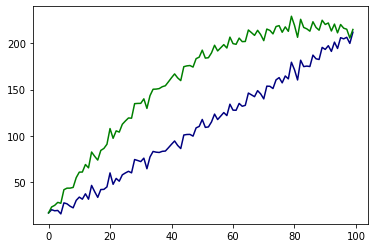

In [3]:
# Sinh quá trình ngẫu nhiên có xu thế tất định
n = 100
at = 5*np.random.randn(n)
y1t = np.array([10 + 2*t + at[t] for t in range(n)])
y2t = np.array([10 + 5*t - 0.03*pow(t,2) + at[t] for t in range(n)])

# Vẽ đồ thị
plt.plot(y1t, color='navy')
plt.plot(y2t, color='green')
plt.show()


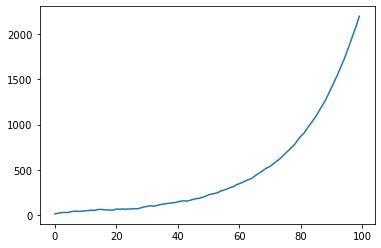

In [4]:
y3t = np.full(n,10)
for i in range(1,n):
    y3t[i]= 1.05*y3t[i-1]+at[i]
    
plt.plot(y3t)
plt.show()

### Mô phỏng bước ngẫu nhiên
$$y_t = y_{t-1} + a_t$$
$$y_t = y_{t-1} + 2+ a_t$$

$$a_t \sim WN(0,25)$$

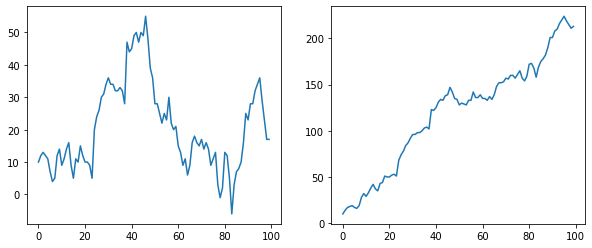

In [5]:
n = 100
at = 5*np.random.randn(n)
y4t = np.full(n,10)
y5t = np.full(n,10)
for i in range(1,n):
    y4t[i] = y4t[i-1] + at[i]
    y5t[i] = y5t[i-1] + 2 + at[i]
    
    
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(y4t)
ax[1].plot(y5t)
plt.show()

### Mô phỏng quá trình ARiMA
$$\nabla^2 y_t = a_t <=> y_t = t_{}$$
$$\nabla^2 y_t = 2+ a_t$$

$$y_0=y_1=10, a_t \sim WN(0,9)$$



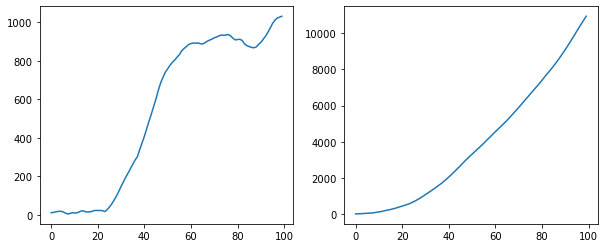

In [6]:
N = 100
AT = 3*np.random.randn(n)
y6t = np.full(n,10)
y7t = np.full(n,10)
for i in range(1,n):
    y6t[i]= 2*y6t[i-1] - y6t[i-2] + at[i]
    y7t[i]= 2*y7t[i-1] - y7t[i-2] + 2 + at[i]
fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(y6t) 
ax[1].plot(y7t)
plt.show()

## Mô hình hoá tỉ giá EUR/USD bằng quá trình ARIMA

In [7]:
start = dt.datetime(2020, 9,1)
end = dt.datetime.now()
df = web.DataReader('EURUSD=X', 'yahoo', start, end)
#df.reset_index(inplace=True)

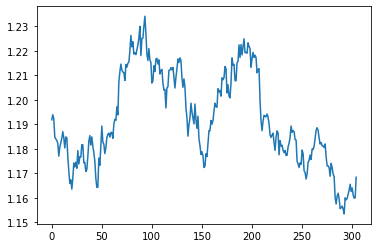

In [8]:
y = df['Adj Close'].values
plt.plot(y)

In [9]:
# Thống kê mô tả cơ bản
n = len(y)
#tb
ytb = y.mean()
#độ lệch chuẩn
s_y = y.std()
print("Gía trị trung bình: ", ytb)
print("Độ lệch chuẩn:" , s_y)

Gía trị trung bình:  1.1919640619246685
Độ lệch chuẩn: 0.018976013855741908


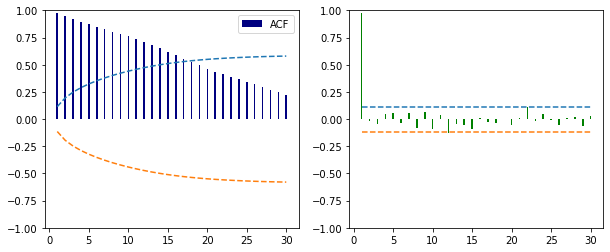

In [10]:
# TÍnh và vẽ biểu đồ tương quan ACF và PACF
K = 30
ACF, se_ACF = sACF(y,K)
PACF, se_PACF = sPACF(y,K)

fig, ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1, K+1)
ax[0].bar(x,ACF, color='navy', width= 0.2 , label="ACF")
ax[0].plot(x, 2*se_ACF, linestyle='dashed')
ax[0].plot(x,-2*se_ACF, linestyle='dashed')
ax[0].set_ylim([-1,1])
ax[0].legend()

ax[1].bar(x,PACF, color='green', width= 0.2 , label="PACF")
ax[1].plot(x, 2*se_PACF, linestyle='dashed')
ax[1].plot(x,-2*se_PACF, linestyle='dashed')
ax[1].set_ylim([-1,1])
ax[0].legend()

plt.show()


* Nhận xét: Hàm ACF giảm chậm và tuyến tính về 0, nên chuỗi tỉ giá là quá trình không dừng => lấy sai phân chuỗi $y_t$ và khảo sát tiếp.

In [11]:
# Tính sai phân
dy = np.diff(y)


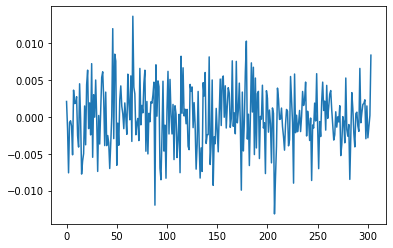

In [12]:
plt.plot(dy)

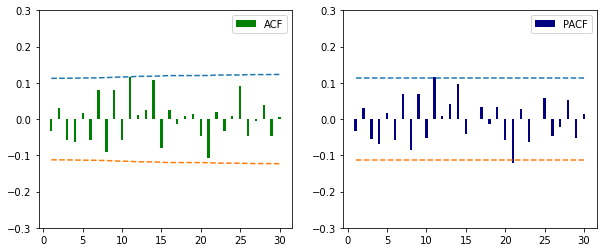

In [13]:
ACF, se_ACF = sACF(dy,K)
PACF, se_PACF = sPACF(dy,K)


# Vẽ đồ thị
fig,ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1,K+1)
ax[0].bar(x, ACF, color='green', width = 0.3, label='ACF')
ax[0].plot(x, 1.96*se_ACF, linestyle='dashed')
ax[0].plot(x, -1.96*se_ACF, linestyle='dashed')
ax[0].set_ylim([-0.3, 0.3])
ax[0].legend()

ax[1].bar(x, PACF, color='navy', width = 0.3, label='PACF')
ax[1].plot(x, 1.96*se_PACF, linestyle='dashed')
ax[1].plot(x, -1.96*se_PACF, linestyle='dashed')
ax[1].set_ylim([-0.3, 0.3])
ax[1].legend()
plt.show()

* Nhận xét: Từ biểu đồ chuỗi sai phân và lược đồ tương quan ACF, PACF, ta thấy chuỗi sai phân $\nabla y_t = y_t - y_{t-1}$ là nhiễu trắng $a_t$
* Do đó, mô hình tỉ giá là 
$$y_t = y_{t-1}+a_t$$
Đây là bước ngẫu nhiên.

Q: Mô hình tỉ giá EURO/USD là bước ngẫu nhiên
$y_t = y_{t-1} + a_t $ nghĩa là $y_t \sim I(1)$

, hay là quá trình AR(1) với hệ số hồi quy $\phi$ gần 1.
$y_t = \phi y_{t-1} +a_t$ nghĩa là $y_t \sim I(0)$

  # 
  # 
  # Kiểm định  nghiệm đơn vị

#### Mô hình tỉ giá EUR/USD
$Q:$ Mô hình tỉ giá EUR/USD là bước ngẫu nhiên
    $y_t = y_{t-1} +a_t$ nghĩa là} $y_t \sim I(1)$
    hay quá trình AR(1) với hệ số hồi quy $\phi$ gần 1:
    $$y_t = \phi_0 + \phi y_{t-1} +a_t,\hbox{nghĩa là} y_t \sim I(0) $$

**A:** để trả lời câu hỏi, ta sử dụng thống kê Dickey-Fuller:
$$\tau = \dfrac{\widehat{\phi}-1}{se(\widehat{\phi})}$$

In [14]:
y = df['Adj Close'].values

# Ước lượng tham số mô hình AR(1): y_t = \theta_0 + \phi y(t-1) + a(t)
model = LinearRegression(fit_intercept = False)
ydata = y[1:]
n = len(ydata)
X = np.vstack([np.ones(n), y[:-1]]).T
model.fit(X,ydata)

#Sai số tiêu chuẩn của ước lượng tham số mô hình
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-2))
se_param = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print('sigma = ', sigma)
                
# Hiển thị dạng bảng
df = pd.DataFrame(np.vstack([model.coef_, se_param]).T,
                 columns=['parameter', 'se(parameter)'])
df

sigma =  0.00416398877206605


,parameter,se(parameter)
0,0.025715,0.015018
1,0.978363,0.012597


In [15]:
# Tính thống kê Dicker-Fuller
t_m = (df['parameter'][1]-1)/df['se(parameter)'][1]
print("giá trị thống kê ADF", t_m)

giá trị thống kê ADF -1.7176767378747442


Ở mức ý nghĩa 5%, giá trị tới hạn của thống kê ADF, là: -2.86 (nghĩa là miền bác bỏ ($-\infty; -2.86$))
> Suy ra mô hỉnh bước ngẫu nhiên là phù hợp hơn

## Kiểm định xem chỉ số S&P 500 là dừng xu nthế (TS) hay  dừng sai phân (DS)?

In [16]:
start = dt.datetime(1990,1,1)
end = dt.datetime.now()
df = web.DataReader('^GSPC', 'yahoo', start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,359.690002,351.980011,353.399994,359.690002,162070000,359.690002
1990-01-03,360.589996,357.890015,359.690002,358.760010,192330000,358.760010
1990-01-04,358.760010,352.890015,358.760010,355.670013,177000000,355.670013
1990-01-05,355.670013,351.350006,355.670013,352.200012,158530000,352.200012
1990-01-08,354.239990,350.540009,352.200012,353.790009,140110000,353.790009
...,...,...,...,...,...,...
2021-10-25,4572.620117,4537.359863,4553.689941,4566.479980,3250210000,4566.479980
2021-10-26,4598.529785,4569.169922,4578.689941,4574.790039,2866500000,4574.790039
2021-10-27,4584.569824,4551.660156,4580.220215,4551.680176,3259510000,4551.680176


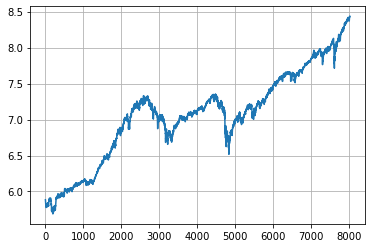

In [17]:
# Log-transform
y = np.log(df['Adj Close'].values)
plt.plot(y)
plt.grid()

**Q:** Ta sẽ kiểm định xem chỉ số S&P 500 là quá trình dừng sai phân 
$$ \nabla y_t = \theta_0 +\theta(B)a_t$$
hay là quá trình dừng xu thế
$$\nabla y_t = \beta_0 + \beta_1t +  \theta(B)a_t$$

**A:** Để trả lời câu hỏi, ta ước lượng mô hình hồi quy ADF:
$$y_t = \beta_0 + \beta_1 +\phi y_{y-1} + \delta_1 \nabla y_{t-1} + a_t$$ 



In [18]:
# ƯỚc lượng tham số mô hình ADF:
model = LinearRegression(fit_intercept=False)
ydata = y[2:]
n = len(ydata)
X = np.vstack([np.ones(n), np.arange(n),y[1:-1],y[1:-1]-y[:-2]]).T
model.fit(X,ydata)

# Sai số tiêu chuẩn của ước lượng tham số mô hình
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-4))
se_param = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print('sigma = ', sigma)
                
# Hiển thị dạng bảng
df = pd.DataFrame(np.vstack([model.coef_, se_param]).T,
                 columns=['parameter', 'se(parameter)'])
df



sigma =  0.011374696273996928


,parameter,se(parameter)
0,5.716078e-03,3.199881e-03
1,2.463810e-07,1.433771e-07
2,9.990994e-01,5.270468e-04
3,-8.672787e-02,1.112903e-02


In [19]:
# Tính thống kê Dicker-Fuller
t_m = (df['parameter'][2]-1)/df['se(parameter)'][2]
print("giá trị thống kê ADF", t_m)

giá trị thống kê ADF -1.7087158605357016


> Ở mức ý nghĩa 5%, giá trị tới hạn của thống kê ADF là: -3.41 
(nghĩa là miền bác bỏ là($\infty; -3.41$)
> Suy ra hình dừng sai phân là phù hợp hơn

# 
# Dự báo chuỗi nhiệt độ của quá trình hoá học
#### Box and Jenkins, Time Series Analysis, Forecasting and Control, Series C

In [20]:
temperature = pd.read_excel('data/chemical process.xlsx')
temperature

,Temperature readings
0,26.6
1,27.0
2,27.1
3,27.1
4,27.1
...,...
221,19.7
222,19.3
223,19.1
224,19.0


#### Chúng ta đã biết, chuỗi nhiệt độ được mô hinh hoá bởi quá trình ARMIA (1,1,0):
$$\nabla y_t = \phi\nabla y_{t-1} + a_t$$

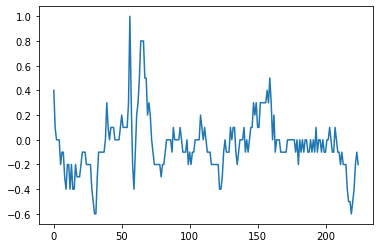

In [21]:
y = temperature['Temperature readings'].values
dy = np.diff(y)
dy.mean()
plt.plot(dy)
plt.show()

In [22]:
# Xây dựng mô hình
model = LinearRegression(fit_intercept = False)
ydata = dy[1:]
X = dy[:-1].reshape(-1,1)
model.fit(X, ydata)
phi = model.coef_[0]
print("Phi= ",phi)
print(f'Mô hình có dạng: dy(t) = {model.coef_[0]} dy(t-1)+ a(t)')

at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(ydata-1)))
print("sigma=", sigma)

Phi=  0.8131147540983602
Mô hình có dạng: dy(t) = 0.8131147540983602 dy(t-1)+ a(t)
sigma= 0.13386263013654193


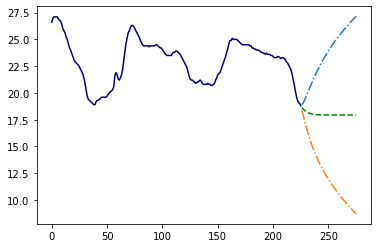

In [23]:
phi1 = 1 + phi
# Xác định giá trị dự báo
h = 50 # thời hạn dự báo
y_forecast = np.zeros(h)
y_forecast[0] = phi1*y[-1] - phi*y[-2]
y_forecast[1] = phi1*y_forecast[0] - phi*y[-1]

for i in range(2,h):
    y_forecast[i]= phi1*y_forecast[i-1] - phi*y_forecast[i-2]

# Tìm trọng số psi trong biểu diễn MA(infinity)
psi = np.zeros(h)
psi[0] = 1
psi[1] = phi1
for i in range(2,h):
    psi[i] = phi1*psi[i-1] - phi*psi[i-2]
    
# Độ lệch tiêu chuẩn của sai số dự báo
sigma_h = sigma*np.array([np.sqrt(np.sum(psi[:j]**2)) for j in range(1,h+1)])
z = 1.96 # Phân vị chuẩn ở mức xác suất alpha = 5%
UCL = y_forecast + z*sigma_h #Upper confidence limit
LCL = y_forecast - z*sigma_h #Lower confidence limit    

 #  Ve do thi
T = len(y)
x_past = np.arange(T)
x_future = np.arange(h) + T
x = np.concatenate([x_past, x_future])
plt.plot(x_past, y, color='navy')
plt.plot(x_future, y_forecast, color='green', linestyle='dashed')
plt.plot(x_future, UCL, linestyle='dashdot')
plt.plot(x_future, LCL, linestyle='dashdot')

# 
# Dự báo chỉ số S&P 500 bằng quá trình dừng xu thế

$$y_t = \beta_0 +\beta_1t + \epsilon_t$$
$$\epsilon_t = \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + a_t$$

In [24]:
start = dt.datetime(1980,1,1)
end = dt.datetime.now()
df = web.DataReader('^GSPC', 'yahoo', start, end)
df.reset_index(inplace=True)
df



,Date,High,Low,Open,Close,Volume,Adj Close
0,1979-12-31,108.529999,107.260002,0.000000,107.940002,31530000,107.940002
1,1980-01-02,108.430000,105.290001,0.000000,105.760002,40610000,105.760002
2,1980-01-03,106.080002,103.260002,0.000000,105.220001,50480000,105.220001
3,1980-01-04,107.080002,105.089996,0.000000,106.519997,39130000,106.519997
4,1980-01-07,107.800003,105.800003,0.000000,106.809998,44500000,106.809998
...,...,...,...,...,...,...,...
10545,2021-10-25,4572.620117,4537.359863,4553.689941,4566.479980,3250210000,4566.479980
10546,2021-10-26,4598.529785,4569.169922,4578.689941,4574.790039,2866500000,4574.790039
10547,2021-10-27,4584.569824,4551.660156,4580.220215,4551.680176,3259510000,4551.680176
10548,2021-10-28,4597.549805,4562.839844,4562.839844,4596.419922,3197560000,4596.419922


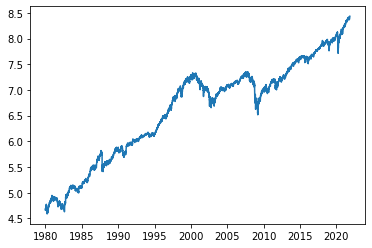

In [25]:
# Log-transform
x = df['Date']
y = np.log(df['Adj Close']).values
plt.plot(x,y)

In [26]:
# Xác định xu thế tuyến tính của quá trình
model = LinearRegression(fit_intercept = False)
T = len(y)
X = np.vstack([np.ones(T), np.arange(T)]).T
model.fit(X,y)
beta0, beta1 = model.coef_
print(f'Beta0 ={beta0}, beta1 = {beta1}')

# Xác dịnh quá trình dùng của sai số ngẫu nhiên 

et = y - model.predict(X)
e = et[2:]
X1 = np.vstack([et[1:-1], et[:-2]]).T
model.fit(X1,e)
phi1, phi2 = model.coef_

print(f'phi1 = {phi1}, phi2 = {phi2}')


Beta0 =5.000458530266719, beta1 = 0.0003071100615049839
phi1 = 0.9438082515871267, phi2 = 0.055289022061124245


#### Yêu cầu
* Đánh giá mô hình: cụ thể kiểm tra xem a(t) có phải là nhiễu trắng hay không

* Tính các giá trị dự báo của y(T+h) với h cho trước tuỳ ý
* Tính khoảng dự báo
* Vẽ đồ thị biểu diễn 

In [27]:
# Kiểm định a(t) có phải nhiễu trắng hay không?
at = e - model.predict(X1)
Qstat(at,24) #Lớn, p-value xấp xỉ 0 => mô hình chưa tốt

91.45138262921954

MÔ hình (logarit) chỉ số S&P 500: 
$$y_t = \beta_0 + \beta_1 t + \epsilon_t$$
$$\epsilon_t = \phi_1\epsilon_{t-1}+\phi_2\epsilon_{t-2} +a_t$$

* Gía trị dự báo
$$\widehat{y}_{T,h}=\beta_0 + \beta_1 (T+h) + \widehat{\epsilon}_{T,h}$$

trong đó:

$$\widehat{\epsilon}_{T,1}=\phi_1\epsilon_{T}+\phi_2\epsilon_{T-1}$$
$$\widehat{\epsilon}_{T,2}=\phi_1\widehat{\epsilon}_{T,1}+\phi_2\epsilon_{T}$$

$$\widehat{\epsilon}_{T,h}=\phi_1 \widehat{\epsilon}_{T,h-1}
+ \phi_2\widehat{\epsilon}_{T, h-2}
$$


jjj=$$

In [28]:
# Tính giá trị dự báo
h = 1000 # THời gian dự báo
e_forecast = np.zeros(h)
e_forecast[0] = phi1*e[-1] - phi2*e[-2]
e_forecast[1] = phi1*e_forecast[0]-phi2*e[-1]
for i in range(2,h):
    e_forecast[i] = phi1*e_forecast[i-1] - phi2*e_forecast[i-2]
    
y_forecast = beta0 + beta1*(T + np.arange(1,h+1)) + e_forecast

print(np.vstack([e_forecast, y_forecast]).T)


[[1.73190116e-01 8.41396690e+00]
 [1.52686971e-01 8.39377087e+00]
 [1.34531711e-01 8.37592272e+00]
 ...
 [2.55186451e-56 8.54696552e+00]
 [2.24833313e-56 8.54727263e+00]
 [1.98090526e-56 8.54757974e+00]]


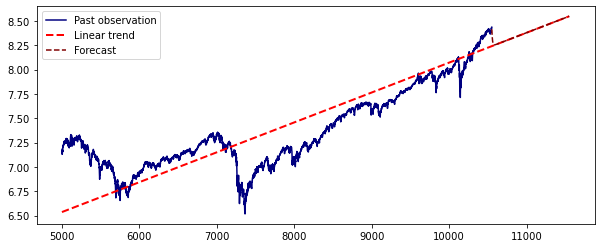

In [29]:
# Vẽ đồ thị 
plt.subplots(figsize=(10,4))
x_past = np.arange(T)
x_future = np.arange(h) + T
x = np.concatenate([x_past, x_future])
y_trend = beta0 + beta1*x[5000:]

plt.plot(x_past[5000:], y[5000:], color='navy',
         label='Past observation')


plt.plot(x[5000:],y_trend, color='red',label='Linear trend',
         linestyle='dashed', linewidth=2)

plt.plot(x_future, y_forecast, color='maroon', 
         linestyle='dashed', label='Forecast')

# plt.plot(x_future, UCL, linestyle='dashdot')
# plt.plot(x_future, LCL, linestyle='dashdot')

plt.legend()
plt.show()

In [30]:
print(y[-1],
y_forecast[0])

8.434980438840205 8.413966904825655


$$\epsilon_t = \phi_1 \epsilon_{t-1} +\phi_2\epsilon_{t-2} + a_t$$
hay
$$(-1-\phi_1B -\phi_2 B^2)\epsilon_t = a_t $$
Trọng số $\psi$ được tìm từ cân bằng hệ thức:
$$(1+\psi_1 B + \psi_2 B^2 + \cdots)(1-\phi_1 B - \phi_2 B^2) = 1$$
THu được
$$\psi_0 = 1$$
$$\psi_1 = \phi_1$$
$$\psi_2 = \psi_1*\phi_1 + \psi_0*\phi_2$$
$$\psi_3 = \psi_2*\phi_1 + \psi_1*\phi_2$$

In [31]:
# Tìm trọng số psi trong biểu diễn MA(infinity)
psi = np.zeros(h)
psi[0] = 1
psi[1] = phi1
for i in range(2,h):
    psi[i] = phi1*psi[i-1] - phi2*psi[i-2]

#KHoảng dự báo
sigma_h = sigma*np.array([np.sqrt(np.sum(psi[:j]**2)) for j in range(1, h+1)])
z = 1.96
UCL = y_forecast + z*sigma_h # Upper confidence limit
LCL = y_forecast - z*sigma_h # Lower confidence limit


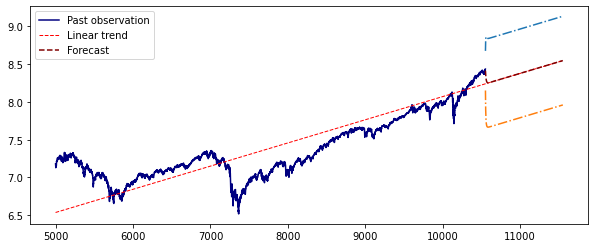

In [32]:
# Vẽ đồ thị 
plt.subplots(figsize=(10,4))
x_past = np.arange(T)
x_future = np.arange(h) + T
x = np.concatenate([x_past, x_future])
y_trend = beta0 + beta1*x[5000:]

plt.plot(x_past[5000:], y[5000:], color='navy',
         label='Past observation')


plt.plot(x[5000:],y_trend, color='red',label='Linear trend',
         linestyle='dashed', linewidth=1)

plt.plot(x_future, y_forecast, color='maroon', 
         linestyle='dashed', label='Forecast')

plt.plot(x_future, UCL, linestyle='dashdot')
plt.plot(x_future, LCL, linestyle='dashdot')

plt.legend()
plt.show()

# 
# 
# Mô hình hoá chuỗi có tính mùa
#### Thành phần mùa tất định
$$y_t = \sum_{i=1}^m \alpha_i s_{i,t} +\epsilon_t,\ \ \epsilon_t \sim ARIMA(p,d,q)$$

In [33]:
# Tải dữ liệu doanh số bán lẻ đồ uống có cồn Mỹ (theo quý)

df = pd.read_excel('data/Retail Sales.xls')
df.head()

,Year,Q1,Q2,Q3,Q4
0,1992,4647,5272,5544,6224
1,1993,4821,5301,5434,5982
2,1994,4767,5444,5662,6228
3,1995,4781,5369,5592,6265
4,1996,5168,5713,5877,6399


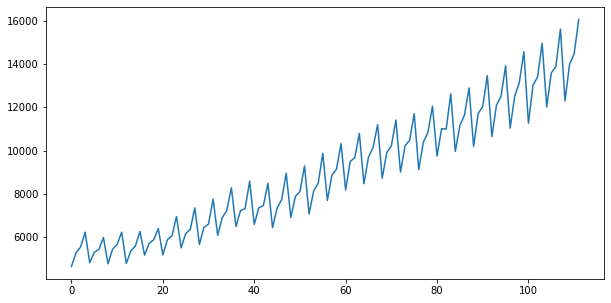

In [34]:
y1 = df['Q1'].values
y2 = df['Q2'].values
y3 = df['Q3'].values
y4 = df['Q4'].values
y = np.vstack([y1,y2,y3,y4]).flatten('F')

# Vẽ đồ thị 
plt.subplots(figsize=(10,5))
plt.plot(y)


Tìm mô hình dưới dạng:
$$y_t = \sum_{i=1}^m \alpha_i s_{i,t} + \beta_1 t + a_t,\ \ a_t \sim WN(0,\sigma^2) $$

<BarContainer object of 30 artists>

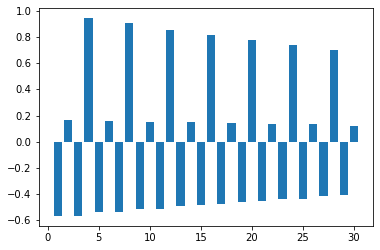

In [35]:
dy = np.diff(y)
ACF = sACF(dy,30)[0]
k = np.arange(1,31)
plt.bar(k,ACF)

[3251.31280788 4224.54611385 4424.5651341  5488.51272578   84.26669403]


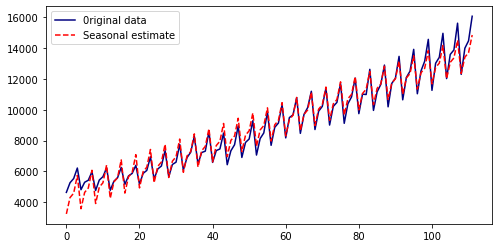

In [44]:
model = LinearRegression(fit_intercept=False)
T = len(y)
s1 = np.zeros(T)
s2 = np.zeros(T)
s3 = np.zeros(T)
s4 = np.zeros(T)

for i in range(T):
    if i%4 == 0:
        s1[i] = 1
    elif i%4 == 1:
        s2[i]=1
    elif i%4 == 2:
        s3[i] = 1
    else:
        s4[i] = 1
        
X = np.vstack([s1,s2,s3,s4, np.arange(T)]).T


model.fit(X,y)

print(model.coef_)

# Ve do thi
yfit = model.predict(X)
plt.subplots(figsize = (8,4))
plt.plot(y, color='navy', label='0riginal data')
plt.plot(yfit, color='red', label='Seasonal estimate', linestyle='dashed')
plt.legend()
plt.show()

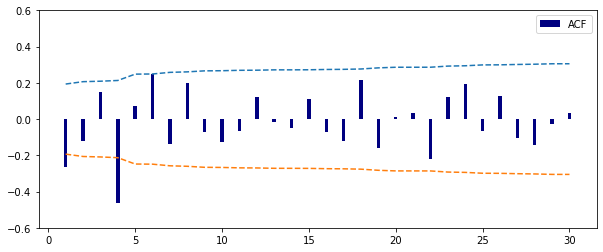

In [50]:
# Lấy sai phân mùa
dy1 = np.diff(y1)
dy2 = np.diff(y2)
dy3 = np.diff(y3)
dy4 = np.diff(y4)
d_m_y =  np.vstack([dy1, dy2, dy3, dy4]).flatten('F') # xếp theo cột
# Lấy sai phân bậc nhất
dd_m_y = np.diff(d_m_y)
ACF, se_ACF = sACF(dd_m_y, 30)



fig, ax = plt.subplots(figsize = (10,4))
x = np.arange(1,31)
ax.bar(x,ACF,color='navy', width=0.2, label='ACF')
ax.plot(x,2*se_ACF, linestyle='dashed')
ax.plot(x,-2*se_ACF, linestyle='dashed')
ax.set_ylim([-0.6,0.6])
ax.legend()


=> Có thể dùng mô hình ARIMA$(0,1,1)(0,1,1)_4$ để mô hình hoá chuỗi doanh số  $$\nabla\nabla_4 y)t = (-1-\theta B)(1-\Theta B)a_t$$
hay
$$\nabla\nabla_4 y_t = a_t - (\theta+\Theta)a_{t-1}+\theta\Theta a_{t-2}$$

In [52]:
ydata = dd_m_y[2:]
X = np.vstack([dd_m_y[1:-1],dd_m_y[0:-2]]).T
model = LinearRegression(fit_intercept=False)
model.fit(X,ydata) 
print(model.coef_)

[-0.32638872 -0.20488637]


In [37]:
from scipy.optimize import curve_fit

In [38]:
def func(x,a,b):
    return a*x[0] + b*x[1] + a*b*x[2]

# Ước lượng cho a(t) - chưa chính xác:
at = dd_m_y
#Ước lượng các tham số mô hình
at5 = at[:-5]
at4 = at[1:-4]
at1 = at[4:-1]
X = np.vstack([at1,at4,at5]).T
Y = dd_m_y[5:]
popt, pcov = curve_fit(func, X,Y)
print('Parameters:', popt)
print('Standard errors of estimation', np.sqrt(np.diag(pcov)))


NameError: name 'dd_m_y' is not defined